# Análisis de Intensidad en un sistema UV


In [1]:
#El método que se aplica para la luminosidad
#se basta con el ISL inversed squared law.

#Se toma el valor medio de las coordenadas de la lampara
#para tomarse como una fuente puntual.

# Version 2.0
''' 
Cálculo de dosis entregada por lampara UV
usando el método de View Factor.
'''
import numpy as np
from time import time 
from tqdm import tqdm_notebook 
import warnings
warnings.filterwarnings('ignore')
    
import numexpr as ne
ne.set_num_threads(8) 

#Mi procesador es octacore ;) 
#el compilador de python no permite el multi thread
#por lo cual este truco de acelerar con la libreria 
#numexpr lo ocupare para los calculos en funciones
#transcendentales u otras operaciones más complejas



#parametros de la lampara

global radio
radio=1     #en cm
global long_lamp
long_lamp=10         #en cm

intensidad_sup=110        #en microW/cm2


#Inicialmente se necesita crear un espacio vectorial 
#con las coordenadas de un ambiente.

ladox=30
ladoy=30
ladoz=30

#Posiciones por extremales de cada lampara 
#Posicion inicial
lampx1=np.array([3])
lampy1=np.array([3])
lampz1=np.array([3])

#posicion final
lampx2=np.array([3])
lampy2=np.array([3])
lampz2=np.array([13])

#asumimos un eje cartesiano como la base Z

z2=lampz1+(long_lamp/2)  #la coodenada de punto medio.


ix = np.arange(0, ladox+1, 1).astype(np.float16)   # se construye una base vectorial
iy = np.arange(0, ladoy+1, 1).astype(np.float16)   # ix, iy, iz  
iz = np.arange(0, ladoz+1, 1).astype(np.float16)   # y se escala los puntos de analisis de los ejes

xx,yy,zz = np.meshgrid(ix, iy, iz, indexing='ij')
#la funcion meshgrid construye vectores que contiene
#las combinaciones de los puntos separadamente


#Para poder ejecutar el calculo geometrico por cada punto
# i,j,k reordenamos la combinación de meshgrid en 
#un solo vector 

x=xx.ravel()
y=yy.ravel()
z=zz.ravel()

coord=np.dstack((x,y,z))  #se crea el espacio vectorial de las coordenadas
#es como si ordenara la progresión barriendo plano a plano
#y linea por linea en el orden: x,y,z


#se calcula la distancia para cada punto que se genera en coord

dist=np.sqrt((coord[0,:,0]-lampx1)**2+(coord[0,:,1]-lampy1)**2+(coord[0,:,2]-z2)**2)

#para aplicar ISL tomamos de referencia el valor de intensidad superficial

Intensidad1=[intensidad_sup*((radio+0.1/i)**2) if i>radio+0.1 else intensidad_sup for i in dist]
Intensidad=np.array(Intensidad1)
Intensidad= Intensidad/np.max(Intensidad)





Plano Frontal, Corte en X: 


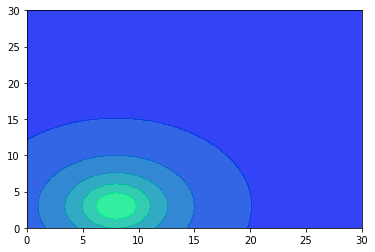

<Figure size 432x288 with 0 Axes>

In [2]:
#Para explorar los resultados, es conveniente recuperar el vector de datos DirectField para
#cada plano de intersección
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

  
#Vista Frontal
#En la vista frontal X es un valor constante
#Z ocupa el valor de x y Y continúa siendo y
print('Plano Frontal, Corte en X: ')
planox=0

#int(input()) # Corte en el medio

ax=np.where(coord[0,:,0]==planox,True,False)
tt=Intensidad[:][ax]

levels = np.linspace(min(tt),max(tt),7,endpoint=True).ravel()

X=np.arange(0,ladoz+1,1)
Y=np.arange(0,ladoy+1,1)
Z=tt.reshape((ladoy+1,ladoz+1))
h = plt.contourf(X,Y,Z,levels,alpha=0.8, cmap=plt.cm.winter)
a=plt.figure()



Plano Frontal, Corte en Y: 


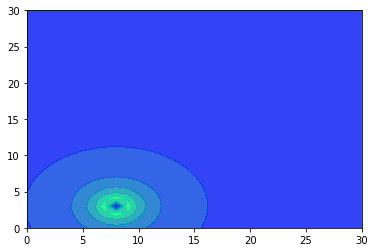

In [3]:
#Para explorar los resultados, es conveniente recuperar el vector de datos DirectField para
#cada plano de intersección
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

  
#Vista Frontal
#En la vista frontal X es un valor constante
#Z ocupa el valor de x y Y continúa siendo y
print('Plano Frontal, Corte en Y: ')
planoy=4  #int(input()) # Corte en el medio

ay=np.where(coord[0,:,1]==planoy,True,False)
tty=Intensidad[:][ay]

levels = np.linspace(min(tty),max(tty),7,endpoint=True).ravel()

X=np.arange(0,ladoz+1,1)
Y=np.arange(0,ladox+1,1)
Z=tty.reshape((ladox+1,ladoz+1))

a=plt.figure()
h = plt.contourf(X,Y,Z,levels,alpha=0.8, cmap=plt.cm.winter)

Plano Frontal, Corte en Y: 


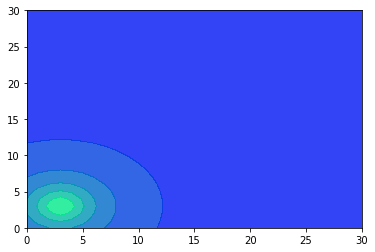

In [6]:
#Para explorar los resultados, es conveniente recuperar el vector de datos DirectField para
#cada plano de intersección
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

  
#Vista Frontal
#En la vista frontal X es un valor constante
#Z ocupa el valor de x y Y continúa siendo y
print('Plano Frontal, Corte en Y: ')
planoz=6  #int(input()) # Corte en el medio

az=np.where(coord[0,:,2]==planoz,True,False)
ttz=Intensidad[:][az]

levels = np.linspace(min(ttz),max(ttz),7,endpoint=True).ravel()

X=np.arange(0,ladox+1,1)
Y=np.arange(0,ladoy+1,1)
Z=ttz.reshape((ladoy+1,ladox+1))

a=plt.figure()
h = plt.contourf(X,Y,Z,levels,alpha=0.8, cmap=plt.cm.winter)

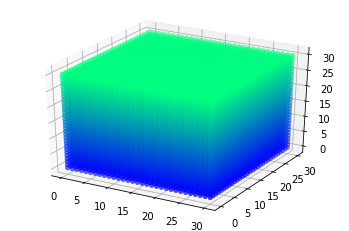

In [5]:
ax = plt.axes(projection='3d')
ax.scatter(xx, yy,zz, Intensidad, c=z, cmap=plt.cm.winter, linewidth=0.5);


# Usando método de View Factor

In [8]:
import math 
import numpy as np
from tqdm import tqdm_notebook 
import warnings

        
def intensidad(IS,arcl,r,x,l):
    #IS,arcl,r son datos de la lampara
    #x es la distancia al eje     -   dist
    #l es la distancia en el eje  -   distaxis
    VF1=VFCylinder(l,r,x)
    VF2=VFCylinder(arcl-l,r,x)
    VF=VF1+VF2
    intense=IS*VF
    return  intense
        
        
        
def intensBey(IS,arcl,r,x,db):
    VF1=VFCylinder(arcl+db,r,x)
    VF2=VFCylinder(db,r,x)
    VF=VF1-VF2
    intense = np.fabs(VF*IS)
    return intense
        
           


def VFCylinder(l, r, h):
    # l= distaxis, r=radius, h=dist
    if(h<r):
        h=r+0.000001 #siempre esta afuera del foco
    H=h/r
    L=l/r
    if(L==0):
        L=0.000001
    if(H==1):
        H=H+0.000001
    X=(1+H)*(1+H)+L*L
    Y=(1-H)*(1-H)+L*L
    a=np.arctan(L/np.sqrt(H*H-1))/L
    b=(X-2*H)*np.arctan(np.sqrt((X/Y)*(H-1)/(H+1)))/np.sqrt(X*Y)
    c=np.arctan(np.sqrt((H-1)/(H+1)))
    VF=L*(a+b-c)/np.pi*H 
    return VF        
        

In [24]:
import math 
import numpy as np
from tqdm import tqdm_notebook 
import warnings
warnings.filterwarnings('ignore')


coord=[]
xend = 30
yend = 30
zend = 30





#distancia hacia el eje de la lámpara para cada coord
dist=[]
#distancias a lo largo del axis de la lámpara para cada coord
distaxis=[]
#Vector de intensidades de la Radiación Directa
DirectField=[]

radio=1
long_lamp=10
intensidad_sup=11


lampx1=3
lampy1=3
lampz1=3

lampx2=3
lampy2=3
lampz2=13

x2=lampx2-lampx1
y2=lampy2-lampy1
z2=lampz2-lampz1
p2=x2*x2+y2*y2+z2*z2
       
                    
for i in range(0,xend+1):
    for j in range(0,yend+1):
        for k in range(0,zend+1):
            coord.append((i,j,k))
            
     
        
for i,j,k in coord:
    x1=i-lampx1
    y1=j-lampy1
    z1=k-lampz1     
    p1=x1*x1+y1*y1+z1*z1
    if (p1*p2>0):
        dotprod= (x1*x2+y1*y2+z1*z2)/(np.sqrt(p1*p2))
        a=np.arccos(dotprod)
        d=abs(np.sin(a))*np.sqrt(p1)
    else: 
        d = 0
    dist.append(d)                    
                 
        
for i,j,k in coord:
    x1=i-lampx1
    y1=j-lampy1
    z1=k-lampz1     
    p1=x1*x1+y1*y1+z1*z1
    if (p1*p2>0):
        dotprod= (x1*x2+y1*y2+z1*z2)/(np.sqrt(p1*p2))
        a=np.arccos(dotprod)
        posit1=abs(np.cos(a))*np.sqrt(p1)
    else: 
        posit1 = 0.000001
    x3=i-lampx2
    y3=j-lampy2
    z3=k-lampz2   
    p3=x3*x3+y3*y3+z3*z3
    p4=x2*x3+y2*y3+z2*z3
    if(p2*p3>0):
        dotprod= p4/(np.sqrt(p3*p2))
        a=np.arccos(dotprod)
        posit2=np.abs(np.cos(a))*np.sqrt(p3)
    else:
        posit2 = 0.000001
    d=max(posit1,posit2)
    distaxis.append(d)
    
    
for i in range(len(distaxis)):
    if distaxis[i]<=long_lamp:
        tempsum=intensidad(intensidad_sup,long_lamp,radio,dist[i],distaxis[i])
    #entradas: IS, arcl,r,x,h
    else:
        db=distaxis[i]-long_lamp
        tempsum=intensBey(intensidad_sup,long_lamp, radio,dist[i],db)
    DirectField.append(tempsum)
        

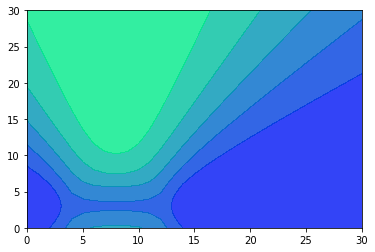

<Figure size 432x288 with 0 Axes>

In [25]:
#Para explorar los resultados, es conveniente recuperar el vector de datos DirectField para
#cada plano de intersección
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

  
#Vista Frontal
#En la vista frontal X es un valor constante
#Z ocupa el valor de x y Y continúa siendo y

planox=1

Z=[] #Los  valores recuperados en orden

for n in range(len(coord)):
    i,j,k = coord[n]
    if (i==planox):
        Z.append(DirectField[n])
 
ZZ=np.array(Z)
levels = np.linspace(min(ZZ),max(ZZ),7,endpoint=True).ravel()

X=np.arange(0,zend+1,1)
Y=np.arange(0,yend+1,1)
Z1=ZZ.reshape((zend+1,yend+1))

h = plt.contourf(X,Y,Z1,levels,alpha=0.8, cmap=plt.cm.winter)
a=plt.figure()

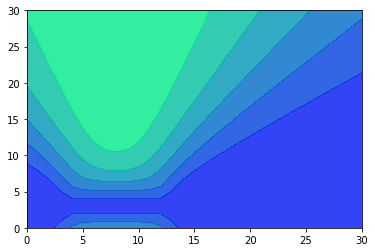

<Figure size 432x288 with 0 Axes>

In [26]:
#Para explorar los resultados, es conveniente recuperar el vector de datos DirectField para
#cada plano de intersección
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

  
#Vista Frontal
#En la vista frontal X es un valor constante
#Z ocupa el valor de x y Y continúa siendo y

planoy=3

Z=[] #Los  valores recuperados en orden

for n in range(len(coord)):
    i,j,k = coord[n]
    if (j==planoy):
        Z.append(DirectField[n])
 
ZZ=np.array(Z)
levels = np.linspace(min(ZZ),max(ZZ),7,endpoint=True).ravel()

X=np.arange(0,zend+1,1)
Y=np.arange(0,xend+1,1)
Z1=ZZ.reshape((zend+1,xend+1))

h = plt.contourf(X,Y,Z1,levels,alpha=0.8, cmap=plt.cm.winter)
a=plt.figure()

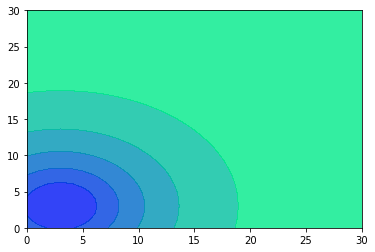

<Figure size 432x288 with 0 Axes>

In [27]:
#Para explorar los resultados, es conveniente recuperar el vector de datos DirectField para
#cada plano de intersección
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

  
#Vista Frontal
#En la vista frontal X es un valor constante
#Z ocupa el valor de x y Y continúa siendo y

planoz=5

Z=[] #Los  valores recuperados en orden

for n in range(len(coord)):
    i,j,k = coord[n]
    if (k==planoy):
        Z.append(DirectField[n])
 
ZZ=np.array(Z)
levels = np.linspace(min(ZZ),max(ZZ),7,endpoint=True).ravel()

X=np.arange(0,xend+1,1)
Y=np.arange(0,yend+1,1)
Z1=ZZ.reshape((xend+1,yend+1))

h = plt.contourf(X,Y,Z1,levels,alpha=0.8, cmap=plt.cm.winter)
a=plt.figure()